***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-2.3)** From coarse-to-Fine slowly decrease the dimension. i.e. 32D>16D>8D (Coarse>Medium>FINE), While keeping the primary capsule dimension same as original ($P_{capsule} = 8D$). Training without $L_{cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\4_CIFAR-100
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "6" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  6
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss')

FOLDER CREATED =  ../../logs/MOD_1/4_CIFAR_100/HD_CapsNet/TD_W_C_loss


# Import Dataset : CIFAR-100

In [5]:
dataset = datasets.CIFAR100(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR100(version = 'reduce') # importing CIFAR10 Dataset


CIFAR-100 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")
    return total_marginloss

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*margin_loss(y_true_m, y_pred_m)
    ML_f = LW_F*margin_loss(y_true_f, y_pred_f)
    batch_loss = ML_c + ML_m+ ML_f
    return tf.reduce_mean(batch_loss)

## Model Architecture

In [11]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = number_of_classes_c
    no_medium_class = number_of_classes_m
    no_fine_class = number_of_classes_f

    PCap_n_dims = 8

    SCap_f_dims = 8
    SCap_m_dims = 16
    SCap_c_dims = 32


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims),
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)
    
    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_c)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [12]:
model = get_compiled_model()

In [13]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.cast (TFOpLambda)           (None,)              0           ['tf.math.argmax_4[0][0]']       
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 1)            0           ['tf.math.reduce_sum_2[0][0]']   
                                                                                                  
 tf.math.argmax (TFOpLambda)    (None,)              0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.argmax_1 (TFOpLambda)  (None,)              0           ['prediction_medium[0][0]']      
                                                                                                  
 tf.math.argmax_5 (TFOpLambda)  (None,)              0           ['input_ym[0][0]']               
          

 da)                                                                                              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.multiply[0][0]']       
 )                                                                                                
                                                                                                  
 tf.math.maximum_4 (TFOpLambda)  (None, 100)         0           ['tf.math.subtract_10[0][0]']    
                                                                                                  
 tf.math.subtract_12 (TFOpLambd  (None, 100)         0           ['input_yf[0][0]']               
 a)                                                                                               
                                                                                                  
 tf.math.m

                                                                                                  
 tf.math.multiply_4 (TFOpLambda  (None,)             0           ['tf.math.abs_2[0][0]',          
 )                                                                'tf.math.abs[0][0]']            
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 100)          0           ['tf.math.multiply_16[0][0]',    
                                                                  'tf.math.multiply_18[0][0]']    
                                                                                                  
 tf.math.abs_3 (TFOpLambda)     (None,)              0           ['tf.math.subtract_3[0][0]']     
                                                                                                  
 tf.math.abs_1 (TFOpLambda)     (None,)              0           ['tf.math.subtract_1[0][0]']     
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.5556 - prediction_coarse_accuracy: 0.4624 - prediction_medium_accuracy: 0.1522 - prediction_fine_accuracy: 0.0100
  • Coarse Accuracy = 46.24% | Val_Accuracy = 51.74% | LossWeight = 0.35 
  • Medium Accuracy = 15.22% | Val_Accuracy = 22.58% | LossWeight = 0.50 
  • Fine   Accuracy = 1.00% | Val_Accuracy = 0.64% | LossWeight = 0.15 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.00640, saving model to ../../logs/MOD_1/4_CIFAR_100/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 63s 68ms/step - loss: 0.5556 - prediction_coarse_accuracy: 0.4624 - prediction_medium_accuracy: 0.1522 - prediction_fine_accuracy: 0.0100 - val_loss: 0.4649 - val_prediction_coarse_accuracy: 0.5174 - val_prediction_medium_accuracy: 0.2258 - val_prediction_fine_accuracy: 0.0064 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.3712 - prediction_coarse_accuracy:

Epoch 18/100
781/781 [==============================] - ETA: 0s - loss: 0.1278 - prediction_coarse_accuracy: 0.9176 - prediction_medium_accuracy: 0.8744 - prediction_fine_accuracy: 0.3988
  • Coarse Accuracy = 91.76% | Val_Accuracy = 84.13% | LossWeight = 0.25 
  • Medium Accuracy = 87.44% | Val_Accuracy = 73.64% | LossWeight = 0.34 
  • Fine   Accuracy = 39.88% | Val_Accuracy = 36.14% | LossWeight = 0.42 

Epoch 18: val_prediction_fine_accuracy improved from 0.34130 to 0.36140, saving model to ../../logs/MOD_1/4_CIFAR_100/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 52s 67ms/step - loss: 0.1278 - prediction_coarse_accuracy: 0.9176 - prediction_medium_accuracy: 0.8744 - prediction_fine_accuracy: 0.3988 - val_loss: 0.1420 - val_prediction_coarse_accuracy: 0.8413 - val_prediction_medium_accuracy: 0.7364 - val_prediction_fine_accuracy: 0.3614 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.1237 - prediction_coar

Epoch 27/100
781/781 [==============================] - ETA: 0s - loss: 0.1064 - prediction_coarse_accuracy: 0.9427 - prediction_medium_accuracy: 0.9204 - prediction_fine_accuracy: 0.5148
  • Coarse Accuracy = 94.27% | Val_Accuracy = 84.94% | LossWeight = 0.24 
  • Medium Accuracy = 92.04% | Val_Accuracy = 75.43% | LossWeight = 0.30 
  • Fine   Accuracy = 51.48% | Val_Accuracy = 44.25% | LossWeight = 0.47 

Epoch 27: val_prediction_fine_accuracy improved from 0.43290 to 0.44250, saving model to ../../logs/MOD_1/4_CIFAR_100/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 52s 66ms/step - loss: 0.1064 - prediction_coarse_accuracy: 0.9427 - prediction_medium_accuracy: 0.9204 - prediction_fine_accuracy: 0.5148 - val_loss: 0.1317 - val_prediction_coarse_accuracy: 0.8494 - val_prediction_medium_accuracy: 0.7543 - val_prediction_fine_accuracy: 0.4425 - lr: 4.1812e-04
Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.1042 - prediction_coar

Epoch 36/100
781/781 [==============================] - ETA: 0s - loss: 0.0977 - prediction_coarse_accuracy: 0.9504 - prediction_medium_accuracy: 0.9354 - prediction_fine_accuracy: 0.5867
  • Coarse Accuracy = 95.04% | Val_Accuracy = 85.59% | LossWeight = 0.24 
  • Medium Accuracy = 93.54% | Val_Accuracy = 76.36% | LossWeight = 0.28 
  • Fine   Accuracy = 58.67% | Val_Accuracy = 48.25% | LossWeight = 0.47 

Epoch 36: val_prediction_fine_accuracy improved from 0.47900 to 0.48250, saving model to ../../logs/MOD_1/4_CIFAR_100/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 54s 69ms/step - loss: 0.0977 - prediction_coarse_accuracy: 0.9504 - prediction_medium_accuracy: 0.9354 - prediction_fine_accuracy: 0.5867 - val_loss: 0.1276 - val_prediction_coarse_accuracy: 0.8559 - val_prediction_medium_accuracy: 0.7636 - val_prediction_fine_accuracy: 0.4825 - lr: 2.6352e-04
Epoch 37/100
781/781 [==============================] - ETA: 0s - loss: 0.0975 - prediction_coar

Epoch 45/100
781/781 [==============================] - ETA: 0s - loss: 0.0933 - prediction_coarse_accuracy: 0.9552 - prediction_medium_accuracy: 0.9421 - prediction_fine_accuracy: 0.6327
  • Coarse Accuracy = 95.52% | Val_Accuracy = 86.01% | LossWeight = 0.25 
  • Medium Accuracy = 94.21% | Val_Accuracy = 76.87% | LossWeight = 0.29 
  • Fine   Accuracy = 63.27% | Val_Accuracy = 51.31% | LossWeight = 0.47 

Epoch 45: val_prediction_fine_accuracy improved from 0.50720 to 0.51310, saving model to ../../logs/MOD_1/4_CIFAR_100/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 54s 69ms/step - loss: 0.0933 - prediction_coarse_accuracy: 0.9552 - prediction_medium_accuracy: 0.9421 - prediction_fine_accuracy: 0.6327 - val_loss: 0.1244 - val_prediction_coarse_accuracy: 0.8601 - val_prediction_medium_accuracy: 0.7687 - val_prediction_fine_accuracy: 0.5131 - lr: 1.6608e-04
Epoch 46/100
781/781 [==============================] - ETA: 0s - loss: 0.0921 - prediction_coar

Epoch 63/100
781/781 [==============================] - ETA: 0s - loss: 0.0892 - prediction_coarse_accuracy: 0.9567 - prediction_medium_accuracy: 0.9446 - prediction_fine_accuracy: 0.6808
  • Coarse Accuracy = 95.67% | Val_Accuracy = 86.21% | LossWeight = 0.26 
  • Medium Accuracy = 94.46% | Val_Accuracy = 77.01% | LossWeight = 0.30 
  • Fine   Accuracy = 68.08% | Val_Accuracy = 52.86% | LossWeight = 0.44 

Epoch 63: val_prediction_fine_accuracy did not improve from 0.53010
781/781 [==============================] - 54s 69ms/step - loss: 0.0892 - prediction_coarse_accuracy: 0.9567 - prediction_medium_accuracy: 0.9446 - prediction_fine_accuracy: 0.6808 - val_loss: 0.1227 - val_prediction_coarse_accuracy: 0.8621 - val_prediction_medium_accuracy: 0.7701 - val_prediction_fine_accuracy: 0.5286 - lr: 6.5971e-05
Epoch 64/100
781/781 [==============================] - ETA: 0s - loss: 0.0904 - prediction_coarse_accuracy: 0.9549 - prediction_medium_accuracy: 0.9438 - prediction_fine_accuracy: 0.

Epoch 72/100
781/781 [==============================] - ETA: 0s - loss: 0.0886 - prediction_coarse_accuracy: 0.9567 - prediction_medium_accuracy: 0.9450 - prediction_fine_accuracy: 0.6936
  • Coarse Accuracy = 95.67% | Val_Accuracy = 86.30% | LossWeight = 0.26 
  • Medium Accuracy = 94.50% | Val_Accuracy = 77.36% | LossWeight = 0.30 
  • Fine   Accuracy = 69.36% | Val_Accuracy = 53.64% | LossWeight = 0.44 

Epoch 72: val_prediction_fine_accuracy did not improve from 0.53700
781/781 [==============================] - 54s 69ms/step - loss: 0.0886 - prediction_coarse_accuracy: 0.9567 - prediction_medium_accuracy: 0.9450 - prediction_fine_accuracy: 0.6936 - val_loss: 0.1228 - val_prediction_coarse_accuracy: 0.8630 - val_prediction_medium_accuracy: 0.7736 - val_prediction_fine_accuracy: 0.5364 - lr: 4.1578e-05
Epoch 73/100
781/781 [==============================] - ETA: 0s - loss: 0.0890 - prediction_coarse_accuracy: 0.9577 - prediction_medium_accuracy: 0.9458 - prediction_fine_accuracy: 0.

781/781 [==============================] - ETA: 0s - loss: 0.0873 - prediction_coarse_accuracy: 0.9594 - prediction_medium_accuracy: 0.9473 - prediction_fine_accuracy: 0.7103
  • Coarse Accuracy = 95.94% | Val_Accuracy = 86.40% | LossWeight = 0.26 
  • Medium Accuracy = 94.73% | Val_Accuracy = 77.49% | LossWeight = 0.30 
  • Fine   Accuracy = 71.03% | Val_Accuracy = 54.19% | LossWeight = 0.43 

Epoch 90: val_prediction_fine_accuracy did not improve from 0.54330
781/781 [==============================] - 53s 68ms/step - loss: 0.0873 - prediction_coarse_accuracy: 0.9594 - prediction_medium_accuracy: 0.9473 - prediction_fine_accuracy: 0.7103 - val_loss: 0.1213 - val_prediction_coarse_accuracy: 0.8640 - val_prediction_medium_accuracy: 0.7749 - val_prediction_fine_accuracy: 0.5419 - lr: 1.6515e-05
Epoch 91/100
781/781 [==============================] - ETA: 0s - loss: 0.0878 - prediction_coarse_accuracy: 0.9592 - prediction_medium_accuracy: 0.9467 - prediction_fine_accuracy: 0.7109
  • Coar

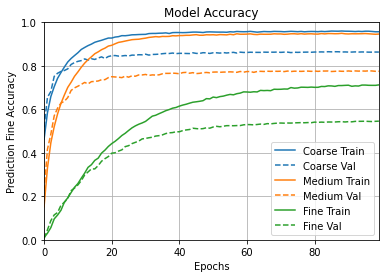

In [17]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

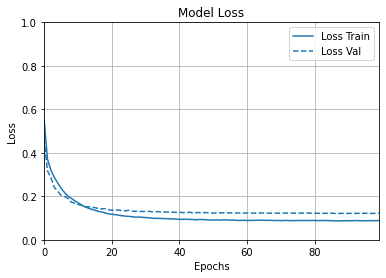

In [18]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [19]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 7s 18ms/step - loss: 0.2392 - prediction_coarse_loss: 0.1048 - prediction_medium_loss: 0.1713 - prediction_fine_loss: 0.3745 - prediction_coarse_accuracy: 0.8634 - prediction_medium_accuracy: 0.7751 - prediction_fine_accuracy: 0.5457
1. loss ==> 0.23917506635189056
2. prediction_coarse_loss ==> 0.1048402190208435
3. prediction_medium_loss ==> 0.1712585687637329
4. prediction_fine_loss ==> 0.3745177090167999
5. prediction_coarse_accuracy ==> 0.8633999824523926
6. prediction_medium_accuracy ==> 0.7750999927520752
7. prediction_fine_accuracy ==> 0.5457000136375427
313/313 [==============================] - 4s 11ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

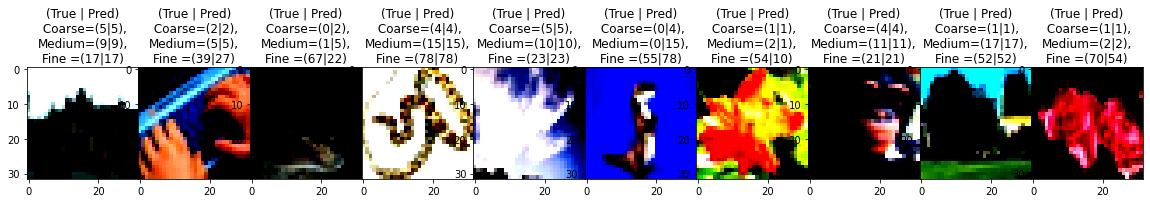

In [20]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 723   15   18   33  173   12   12   14]
 [   6 1363   31   34   43   16    2    5]
 [   8   24 1364   20   30   13   13   28]
 [  19   29   29  797  103    4    5   14]
 [ 100   23   46   97 2186   11   17   20]
 [   8   27   20    5   29  884    0   27]
 [   6   10   13    9   34    1  425    2]
 [   7    3   27   17   22   32    0  892]]

  • MEDIUM LEVEL 
[[317  33   0   3   0   3   2   6  18   1   2  21  23  17   6  24  18   2
    4   0]
 [ 28 360   7   3   6   5   1   6   0   3   4   2   8  11   8  27  10   0
    4   7]
 [  0   4 448   4  14   3   2  13   0   1   2   0   1   2   1   2   1   1
    0   1]
 [  2   2   4 409  10  33  10   2   0   2   1   3   1   7   4   3   0   0
    1   6]
 [  1   0  26   9 421   7   3   3   4   1   0   5   2   9   2   2   4   1
    0   0]
 [  0   5   1  39   5 376  23   3   2   5   1   1   2   2  12  11   0   2
    4   6]
 [  2   1   0  15   1  28 423   4   0   3   3   0   2   1   3   3   1   1
    2   7]


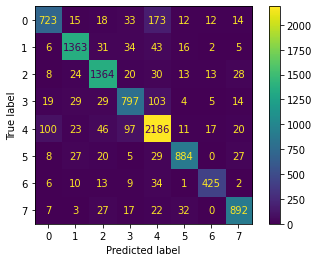

              precision    recall  f1-score   support

           0    0.82440   0.72300   0.77038      1000
           1    0.91232   0.90867   0.91049      1500
           2    0.88114   0.90933   0.89501      1500
           3    0.78755   0.79700   0.79225      1000
           4    0.83435   0.87440   0.85391      2500
           5    0.90853   0.88400   0.89610      1000
           6    0.89662   0.85000   0.87269       500
           7    0.89022   0.89200   0.89111      1000

    accuracy                        0.86340     10000
   macro avg    0.86689   0.85480   0.86024     10000
weighted avg    0.86351   0.86340   0.86292     10000


  • MEDIUM LEVEL 


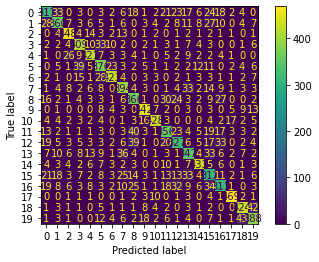

              precision    recall  f1-score   support

           0    0.69518   0.63400   0.66318       500
           1    0.76923   0.72000   0.74380       500
           2    0.85660   0.89600   0.87586       500
           3    0.78805   0.81800   0.80275       500
           4    0.83865   0.84200   0.84032       500
           5    0.71212   0.75200   0.73152       500
           6    0.87216   0.84600   0.85888       500
           7    0.74200   0.78800   0.76431       500
           8    0.69450   0.73200   0.71276       500
           9    0.85825   0.88400   0.87094       500
          10    0.91453   0.85600   0.88430       500
          11    0.71774   0.71200   0.71486       500
          12    0.70172   0.65400   0.67702       500
          13    0.68849   0.69400   0.69124       500
          14    0.86948   0.86600   0.86774       500
          15    0.58318   0.62400   0.60290       500
          16    0.67904   0.62200   0.64927       500
          17    0.92323   0

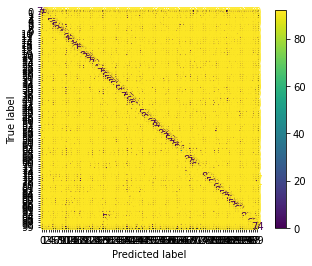

              precision    recall  f1-score   support

           0    0.89655   0.78000   0.83422       100
           1    0.84706   0.72000   0.77838       100
           2    0.37342   0.59000   0.45736       100
           3    0.48684   0.37000   0.42045       100
           4    0.34677   0.43000   0.38393       100
           5    0.51351   0.57000   0.54028       100
           6    0.68478   0.63000   0.65625       100
           7    0.60241   0.50000   0.54645       100
           8    0.84848   0.84000   0.84422       100
           9    0.88312   0.68000   0.76836       100
          10    0.25258   0.49000   0.33333       100
          11    0.41304   0.19000   0.26027       100
          12    0.55000   0.66000   0.60000       100
          13    0.58025   0.47000   0.51934       100
          14    0.36879   0.52000   0.43154       100
          15    0.48421   0.46000   0.47179       100
          16    0.60377   0.64000   0.62136       100
          17    0.85714   0

D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [22]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7273466666666666 
Hierarchical Recall = 0.7399666666666667 
Hierarchical F1-Score = 0.7322845238095238 
Consistency =  0.9211 
Exact Match =  0.5335


# Training Again

In [23]:
model_save_dir = str(directory+'/trained_model_2.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.1176 - prediction_coarse_accuracy: 0.9251 - prediction_medium_accuracy: 0.8908 - prediction_fine_accuracy: 0.5788
  • Coarse Accuracy = 92.51% | Val_Accuracy = 82.38% | LossWeight = 0.28 
  • Medium Accuracy = 89.08% | Val_Accuracy = 72.02% | LossWeight = 0.36 
  • Fine   Accuracy = 57.88% | Val_Accuracy = 46.75% | LossWeight = 0.36 

Epoch 1: val_prediction_fine_accuracy did not improve from 0.54570
781/781 [==============================] - 54s 69ms/step - loss: 0.1176 - prediction_coarse_accuracy: 0.9251 - prediction_medium_accuracy: 0.8908 - prediction_fine_accuracy: 0.5788 - val_loss: 0.1501 - val_prediction_coarse_accuracy: 0.8238 - val_prediction_medium_accuracy: 0.7202 - val_prediction_fine_accuracy: 0.4675 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1153 - prediction_coarse_accuracy: 0.9278 - prediction_medium_accuracy: 0.8965 - prediction_fine_accuracy: 0.5835
  

781/781 [==============================] - 53s 68ms/step - loss: 0.1041 - prediction_coarse_accuracy: 0.9408 - prediction_medium_accuracy: 0.9176 - prediction_fine_accuracy: 0.6401 - val_loss: 0.1319 - val_prediction_coarse_accuracy: 0.8487 - val_prediction_medium_accuracy: 0.7567 - val_prediction_fine_accuracy: 0.5351 - lr: 0.0010
Epoch 11/100
781/781 [==============================] - ETA: 0s - loss: 0.1029 - prediction_coarse_accuracy: 0.9412 - prediction_medium_accuracy: 0.9176 - prediction_fine_accuracy: 0.6520
  • Coarse Accuracy = 94.12% | Val_Accuracy = 84.18% | LossWeight = 0.27 
  • Medium Accuracy = 91.76% | Val_Accuracy = 74.64% | LossWeight = 0.35 
  • Fine   Accuracy = 65.20% | Val_Accuracy = 53.31% | LossWeight = 0.38 

Epoch 11: val_prediction_fine_accuracy did not improve from 0.54570
781/781 [==============================] - 53s 68ms/step - loss: 0.1029 - prediction_coarse_accuracy: 0.9412 - prediction_medium_accuracy: 0.9176 - prediction_fine_accuracy: 0.6520 - val_

Epoch 20/100
781/781 [==============================] - ETA: 0s - loss: 0.0910 - prediction_coarse_accuracy: 0.9531 - prediction_medium_accuracy: 0.9387 - prediction_fine_accuracy: 0.7321
  • Coarse Accuracy = 95.31% | Val_Accuracy = 85.22% | LossWeight = 0.28 
  • Medium Accuracy = 93.87% | Val_Accuracy = 76.45% | LossWeight = 0.34 
  • Fine   Accuracy = 73.21% | Val_Accuracy = 56.65% | LossWeight = 0.38 

Epoch 20: val_prediction_fine_accuracy did not improve from 0.56670
781/781 [==============================] - 53s 68ms/step - loss: 0.0910 - prediction_coarse_accuracy: 0.9531 - prediction_medium_accuracy: 0.9387 - prediction_fine_accuracy: 0.7321 - val_loss: 0.1289 - val_prediction_coarse_accuracy: 0.8522 - val_prediction_medium_accuracy: 0.7645 - val_prediction_fine_accuracy: 0.5665 - lr: 5.9874e-04
Epoch 21/100
781/781 [==============================] - ETA: 0s - loss: 0.0910 - prediction_coarse_accuracy: 0.9539 - prediction_medium_accuracy: 0.9384 - prediction_fine_accuracy: 0.

781/781 [==============================] - ETA: 0s - loss: 0.0854 - prediction_coarse_accuracy: 0.9584 - prediction_medium_accuracy: 0.9477 - prediction_fine_accuracy: 0.8263
  • Coarse Accuracy = 95.84% | Val_Accuracy = 86.32% | LossWeight = 0.32 
  • Medium Accuracy = 94.77% | Val_Accuracy = 77.79% | LossWeight = 0.36 
  • Fine   Accuracy = 82.63% | Val_Accuracy = 60.05% | LossWeight = 0.31 

Epoch 38: val_prediction_fine_accuracy did not improve from 0.60210
781/781 [==============================] - 53s 68ms/step - loss: 0.0854 - prediction_coarse_accuracy: 0.9584 - prediction_medium_accuracy: 0.9477 - prediction_fine_accuracy: 0.8263 - val_loss: 0.1231 - val_prediction_coarse_accuracy: 0.8632 - val_prediction_medium_accuracy: 0.7779 - val_prediction_fine_accuracy: 0.6005 - lr: 2.3783e-04
Epoch 39/100
781/781 [==============================] - ETA: 0s - loss: 0.0847 - prediction_coarse_accuracy: 0.9596 - prediction_medium_accuracy: 0.9475 - prediction_fine_accuracy: 0.8302
  • Coar

781/781 [==============================] - 56s 71ms/step - loss: 0.0830 - prediction_coarse_accuracy: 0.9604 - prediction_medium_accuracy: 0.9501 - prediction_fine_accuracy: 0.8491 - val_loss: 0.1206 - val_prediction_coarse_accuracy: 0.8676 - val_prediction_medium_accuracy: 0.7849 - val_prediction_fine_accuracy: 0.6107 - lr: 1.4989e-04
Epoch 48/100
781/781 [==============================] - ETA: 0s - loss: 0.0835 - prediction_coarse_accuracy: 0.9591 - prediction_medium_accuracy: 0.9484 - prediction_fine_accuracy: 0.8514
  • Coarse Accuracy = 95.91% | Val_Accuracy = 86.76% | LossWeight = 0.34 
  • Medium Accuracy = 94.84% | Val_Accuracy = 78.48% | LossWeight = 0.38 
  • Fine   Accuracy = 85.14% | Val_Accuracy = 60.99% | LossWeight = 0.28 

Epoch 48: val_prediction_fine_accuracy did not improve from 0.61070
781/781 [==============================] - 53s 68ms/step - loss: 0.0835 - prediction_coarse_accuracy: 0.9591 - prediction_medium_accuracy: 0.9484 - prediction_fine_accuracy: 0.8514 - 

Epoch 57/100
781/781 [==============================] - ETA: 0s - loss: 0.0831 - prediction_coarse_accuracy: 0.9593 - prediction_medium_accuracy: 0.9502 - prediction_fine_accuracy: 0.8619
  • Coarse Accuracy = 95.93% | Val_Accuracy = 86.72% | LossWeight = 0.35 
  • Medium Accuracy = 95.02% | Val_Accuracy = 78.60% | LossWeight = 0.38 
  • Fine   Accuracy = 86.19% | Val_Accuracy = 61.32% | LossWeight = 0.27 

Epoch 57: val_prediction_fine_accuracy improved from 0.61260 to 0.61320, saving model to ../../logs/MOD_1/4_CIFAR_100/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 54s 69ms/step - loss: 0.0831 - prediction_coarse_accuracy: 0.9593 - prediction_medium_accuracy: 0.9502 - prediction_fine_accuracy: 0.8619 - val_loss: 0.1220 - val_prediction_coarse_accuracy: 0.8672 - val_prediction_medium_accuracy: 0.7860 - val_prediction_fine_accuracy: 0.6132 - lr: 8.9745e-05
Epoch 58/100
781/781 [==============================] - ETA: 0s - loss: 0.0828 - prediction_coar

781/781 [==============================] - 54s 69ms/step - loss: 0.0827 - prediction_coarse_accuracy: 0.9611 - prediction_medium_accuracy: 0.9503 - prediction_fine_accuracy: 0.8697 - val_loss: 0.1212 - val_prediction_coarse_accuracy: 0.8686 - val_prediction_medium_accuracy: 0.7866 - val_prediction_fine_accuracy: 0.6142 - lr: 5.6562e-05
Epoch 67/100
781/781 [==============================] - ETA: 0s - loss: 0.0827 - prediction_coarse_accuracy: 0.9615 - prediction_medium_accuracy: 0.9513 - prediction_fine_accuracy: 0.8713
  • Coarse Accuracy = 96.15% | Val_Accuracy = 86.95% | LossWeight = 0.34 
  • Medium Accuracy = 95.13% | Val_Accuracy = 78.66% | LossWeight = 0.39 
  • Fine   Accuracy = 87.13% | Val_Accuracy = 61.18% | LossWeight = 0.27 

Epoch 67: val_prediction_fine_accuracy did not improve from 0.61420
781/781 [==============================] - 53s 68ms/step - loss: 0.0827 - prediction_coarse_accuracy: 0.9615 - prediction_medium_accuracy: 0.9513 - prediction_fine_accuracy: 0.8713 - 

Epoch 76/100
781/781 [==============================] - ETA: 0s - loss: 0.0824 - prediction_coarse_accuracy: 0.9613 - prediction_medium_accuracy: 0.9519 - prediction_fine_accuracy: 0.8729
  • Coarse Accuracy = 96.13% | Val_Accuracy = 86.88% | LossWeight = 0.35 
  • Medium Accuracy = 95.19% | Val_Accuracy = 78.56% | LossWeight = 0.39 
  • Fine   Accuracy = 87.29% | Val_Accuracy = 61.39% | LossWeight = 0.27 

Epoch 76: val_prediction_fine_accuracy did not improve from 0.61600
781/781 [==============================] - 53s 68ms/step - loss: 0.0824 - prediction_coarse_accuracy: 0.9613 - prediction_medium_accuracy: 0.9519 - prediction_fine_accuracy: 0.8729 - val_loss: 0.1214 - val_prediction_coarse_accuracy: 0.8688 - val_prediction_medium_accuracy: 0.7856 - val_prediction_fine_accuracy: 0.6139 - lr: 3.3866e-05
Epoch 77/100
781/781 [==============================] - ETA: 0s - loss: 0.0819 - prediction_coarse_accuracy: 0.9613 - prediction_medium_accuracy: 0.9512 - prediction_fine_accuracy: 0.

781/781 [==============================] - 53s 68ms/step - loss: 0.0826 - prediction_coarse_accuracy: 0.9635 - prediction_medium_accuracy: 0.9526 - prediction_fine_accuracy: 0.8790 - val_loss: 0.1212 - val_prediction_coarse_accuracy: 0.8701 - val_prediction_medium_accuracy: 0.7876 - val_prediction_fine_accuracy: 0.6158 - lr: 2.1344e-05
Epoch 86/100
781/781 [==============================] - ETA: 0s - loss: 0.0824 - prediction_coarse_accuracy: 0.9611 - prediction_medium_accuracy: 0.9522 - prediction_fine_accuracy: 0.8760
  • Coarse Accuracy = 96.11% | Val_Accuracy = 86.91% | LossWeight = 0.35 
  • Medium Accuracy = 95.22% | Val_Accuracy = 78.72% | LossWeight = 0.39 
  • Fine   Accuracy = 87.60% | Val_Accuracy = 61.69% | LossWeight = 0.26 

Epoch 86: val_prediction_fine_accuracy did not improve from 0.61790
781/781 [==============================] - 54s 69ms/step - loss: 0.0824 - prediction_coarse_accuracy: 0.9611 - prediction_medium_accuracy: 0.9522 - prediction_fine_accuracy: 0.8760 - 

In [24]:
history_dict = history.history

(0.0, 1.0)

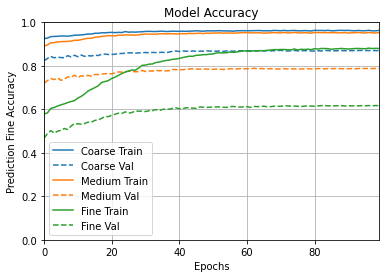

In [25]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

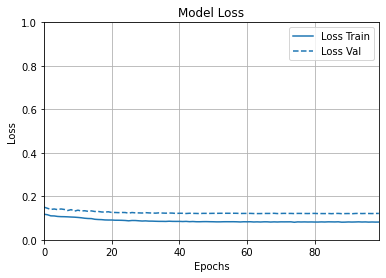

In [26]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"loss": history}, metric = "loss")
plt.title("Model Loss")
plt.ylim([0,1])

## Model Analysis

In [27]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 7s 18ms/step - loss: 0.1812 - prediction_coarse_loss: 0.0997 - prediction_medium_loss: 0.1629 - prediction_fine_loss: 0.3164 - prediction_coarse_accuracy: 0.8693 - prediction_medium_accuracy: 0.7873 - prediction_fine_accuracy: 0.6170
1. loss ==> 0.18123047053813934
2. prediction_coarse_loss ==> 0.09971599280834198
3. prediction_medium_loss ==> 0.16285254061222076
4. prediction_fine_loss ==> 0.3164215087890625
5. prediction_coarse_accuracy ==> 0.8693000078201294
6. prediction_medium_accuracy ==> 0.7872999906539917
7. prediction_fine_accuracy ==> 0.6169999837875366
313/313 [==============================] - 4s 11ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

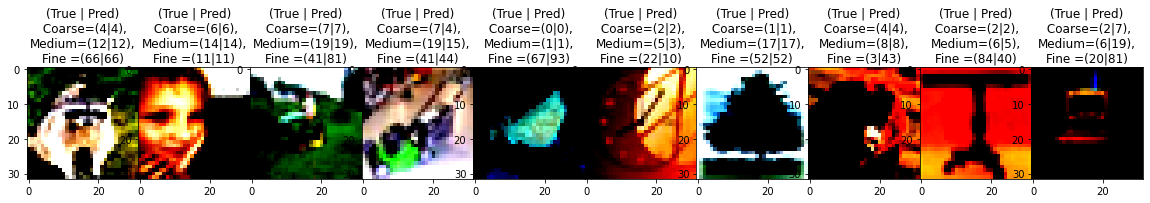

In [28]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 734    9   19   30  172    7   16   13]
 [   6 1377   23   37   35   15    3    4]
 [   6   22 1370   25   26   11   10   30]
 [  20   31   29  810   88    4    7   11]
 [ 104   27   44   93 2188   13    9   22]
 [  12   34   17    5   31  878    1   22]
 [   7   10   14    7   27    0  429    6]
 [   8    4   26   11   18   24    2  907]]

  • MEDIUM LEVEL 
[[328  26   0   1   0   8   1   6  17   1   1  17  19  11   6  35  19   0
    3   1]
 [ 32 365   5   4   5   1   2   7   0   3   5   1   7  11  12  23   9   0
    3   5]
 [  1   2 439   6  23   1   3  11   1   1   1   0   1   5   1   3   0   0
    0   1]
 [  0   1   3 410  14  31   9   3   1   2   0   2   2   7   2   4   0   0
    2   7]
 [  1   2  18   7 431   5   1   6   5   0   1   3   0  11   2   5   2   0
    0   0]
 [  2   6   1  32   9 397  17   0   0   3   4   1   2   5   7   4   1   0
    5   4]
 [  3   0   0  13   1  25 430   3   0   2   1   2   1   2   4   1   0   1
    6   5]


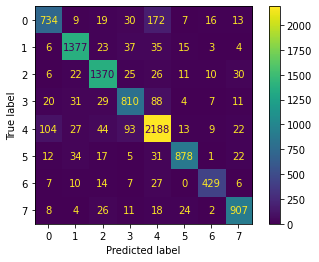

              precision    recall  f1-score   support

           0    0.81828   0.73400   0.77385      1000
           1    0.90951   0.91800   0.91374      1500
           2    0.88846   0.91333   0.90072      1500
           3    0.79568   0.81000   0.80278      1000
           4    0.84642   0.87520   0.86057      2500
           5    0.92227   0.87800   0.89959      1000
           6    0.89937   0.85800   0.87820       500
           7    0.89360   0.90700   0.90025      1000

    accuracy                        0.86930     10000
   macro avg    0.87170   0.86169   0.86621     10000
weighted avg    0.86925   0.86930   0.86887     10000


  • MEDIUM LEVEL 


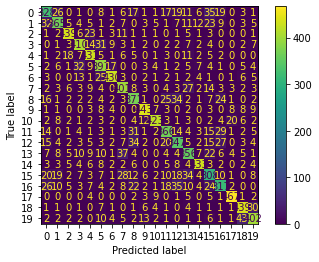

              precision    recall  f1-score   support

           0    0.68908   0.65600   0.67213       500
           1    0.79004   0.73000   0.75884       500
           2    0.88153   0.87800   0.87976       500
           3    0.79922   0.82000   0.80948       500
           4    0.80712   0.86200   0.83366       500
           5    0.73655   0.79400   0.76420       500
           6    0.88660   0.86000   0.87310       500
           7    0.75660   0.80200   0.77864       500
           8    0.71209   0.74200   0.72674       500
           9    0.87897   0.88600   0.88247       500
          10    0.91361   0.84600   0.87850       500
          11    0.75309   0.73200   0.74239       500
          12    0.69819   0.69400   0.69609       500
          13    0.69941   0.71200   0.70565       500
          14    0.88008   0.86600   0.87298       500
          15    0.61600   0.61600   0.61600       500
          16    0.69518   0.63400   0.66318       500
          17    0.91569   0

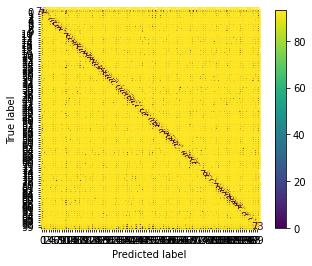

              precision    recall  f1-score   support

           0    0.69725   0.76000   0.72727       100
           1    0.79592   0.78000   0.78788       100
           2    0.46610   0.55000   0.50459       100
           3    0.48780   0.40000   0.43956       100
           4    0.48193   0.40000   0.43716       100
           5    0.57798   0.63000   0.60287       100
           6    0.72826   0.67000   0.69792       100
           7    0.68675   0.57000   0.62295       100
           8    0.81633   0.80000   0.80808       100
           9    0.89024   0.73000   0.80220       100
          10    0.28061   0.55000   0.37162       100
          11    0.39130   0.36000   0.37500       100
          12    0.59829   0.70000   0.64516       100
          13    0.65116   0.56000   0.60215       100
          14    0.48696   0.56000   0.52093       100
          15    0.66216   0.49000   0.56322       100
          16    0.62136   0.64000   0.63054       100
          17    0.89535   0

In [29]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [30]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7550533333333332 
Hierarchical Recall = 0.7696666666666667 
Hierarchical F1-Score = 0.7606904761904761 
Consistency =  0.9064 
Exact Match =  0.6044
